# gpOptimizer: Single-Task Acquisition Functions

In [1]:
#!pip install gpcam==8.1.13

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time
from loguru import logger

%load_ext autoreload
%autoreload 2


In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Preparation

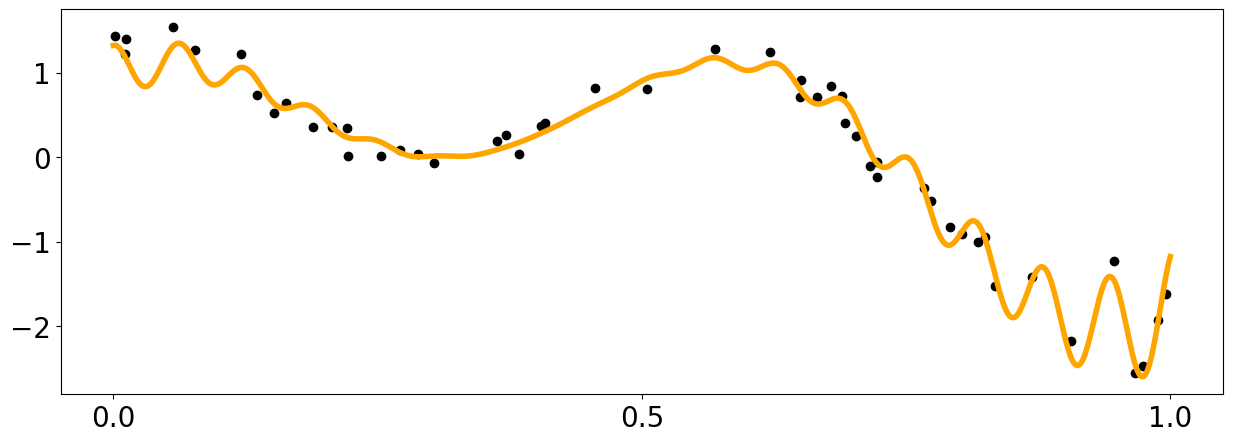

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(50).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

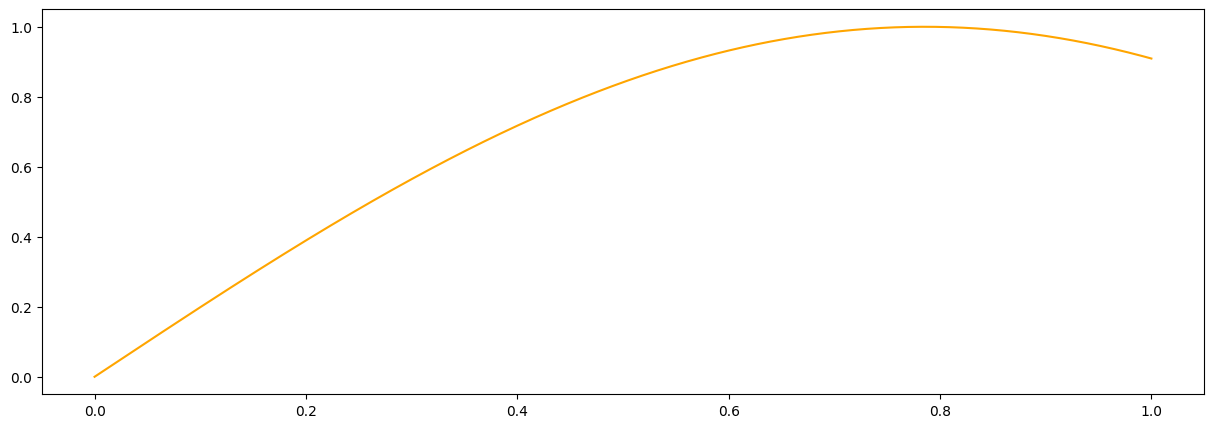

In [5]:
def my_noise(x,hps):
    #This is a simple noise function but can be made arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.zeros((len(x))) + hps[2]

#stationary
from gpcam.gp_kernels import *
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This is a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [6]:


my_gpo = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args={'a': 1.5, 'b':2.},
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,0.1],  #noise
                       [0.001,1.]  #mean
                      ])
my_gpo.tell(x_data, y_data, append=False)
my_gpo.tell(x_data, y_data, append=True)
my_gpo.tell(x_data, y_data)
print("Standard Training")
my_gpo.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='global', info=True)
print("hps: ", my_gpo.get_hyperparameters())
print("Local Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='local', info=True)
print(my_gpo.get_hyperparameters())
print("MCMC Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000, info=True)
print("HGDL Training")
my_gpo.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
differential_evolution step 1: f(x)= 15.969352085469644
differential_evolution step 2: f(x)= 15.969352085469644
differential_evolution step 3: f(x)= 15.969352085469644
differential_evolution step 4: f(x)= 15.969352085469644
differential_evolution step 5: f(x)= 15.969352085469644
differential_evolution step 6: f(x)= 15.969352085469644
differential_evolution step 7: f(x)= 15.969352085469644
differential_evolution step 8: f(x)= 15.969352085469644
differential_evolution step 9: f(x)= 15.969352085469644
differential_evolution step 10: f(x)= 15.969352085469644
differential_evolution step 11: f(x)= 15.969352085469644
differential_evolution step 12: f(x)= 15.969352085469644
differential_evolution step 13: f(x)= 15.969352085469644
differential_evolution step 14: f(x)= 15.969352085469644
differential_evolution step 15: f(x)= 15.969352085469644
differential_evolution step 16: f(x)= 15.969352085469644
differential_evolution step 17: f(x)= 15.969352085469644
differ

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:234: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  OptimumEvaluation = minimize(


Finished  300  out of  1000  iterations. f(x)=  -17.24207904298493
Finished  400  out of  1000  iterations. f(x)=  -18.471052691763095
Finished  500  out of  1000  iterations. f(x)=  -16.75608761191428
Finished  600  out of  1000  iterations. f(x)=  -16.632488761392935
Finished  700  out of  1000  iterations. f(x)=  -19.249137888448416
Finished  800  out of  1000  iterations. f(x)=  -17.90502286576823
Finished  900  out of  1000  iterations. f(x)=  -17.05665590130383
HGDL Training


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


array([1.98137024e+00, 3.70437481e-01, 5.42241884e-02, 1.00000000e-03])

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [7]:
opt_obj = my_gpo.train_async(hyperparameter_bounds=hps_bounds)
for i in range(10):
    my_gpo.update_hyperparameters(opt_obj)
    time.sleep(2)
    print(my_gpo.hyperparameters)
    print("")

my_gpo.stop_training(opt_obj)

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:145: UserWarning:      Hyperparameter update failed with ERROR: list index out of range
  warnings.warn("     Hyperparameter update failed with ERROR: "+str(err))
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, arg

[1.98137024e+00 3.70437481e-01 5.42241884e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]

[1.98137024e+00 3.70437483e-01 5.42241708e-02 1.00000000e-03]



## Calculating on Vizualizing the Results

0.20910094508278557
(np.float64(1.0614041863430743), np.float64(0.9279543575484748))


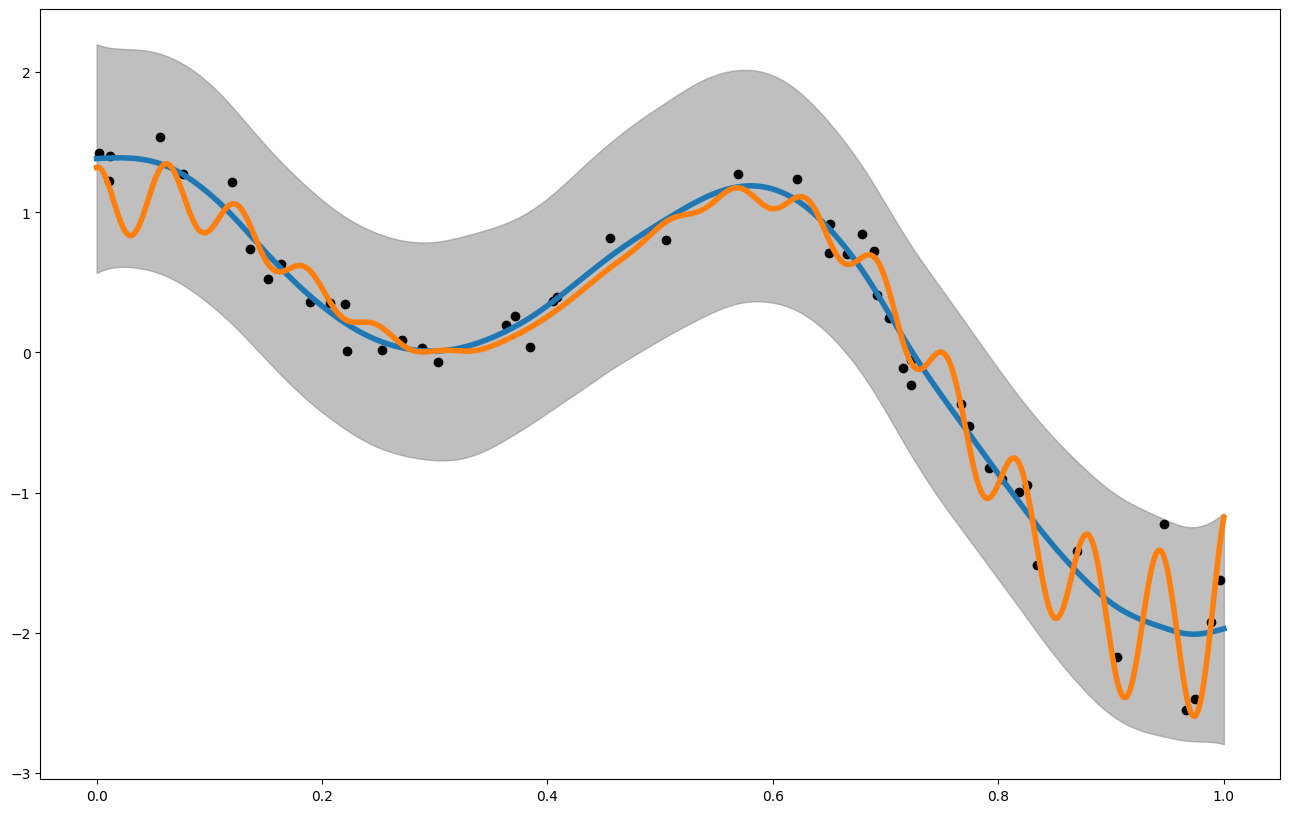

In [8]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gpo.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gpo.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gpo.rmse(x_pred1D,f1(x_pred1D)))
print(my_gpo.crps(x_pred1D,f1(x_pred1D)))

In [9]:
#available acquisition function:
acquisition_functions = ["variance","relative information entropy","relative information entropy set",
                        "ucb","lcb","maximum","minimum","gradient","expected improvement",
                         "probability of improvement", "target probability", "total correlation"]

Acquisition function  variance
Acquisition function  relative information entropy
Some acquisition function return a scalar score for the entirety of points. Here:  relative information entropy
Acquisition function  relative information entropy set
Acquisition function  ucb
Acquisition function  lcb
Acquisition function  maximum
Acquisition function  minimum
Acquisition function  gradient
Acquisition function  expected improvement
Acquisition function  probability of improvement
Acquisition function  target probability
Acquisition function  total correlation
Some acquisition function return a scalar score for the entirety of points. Here:  total correlation


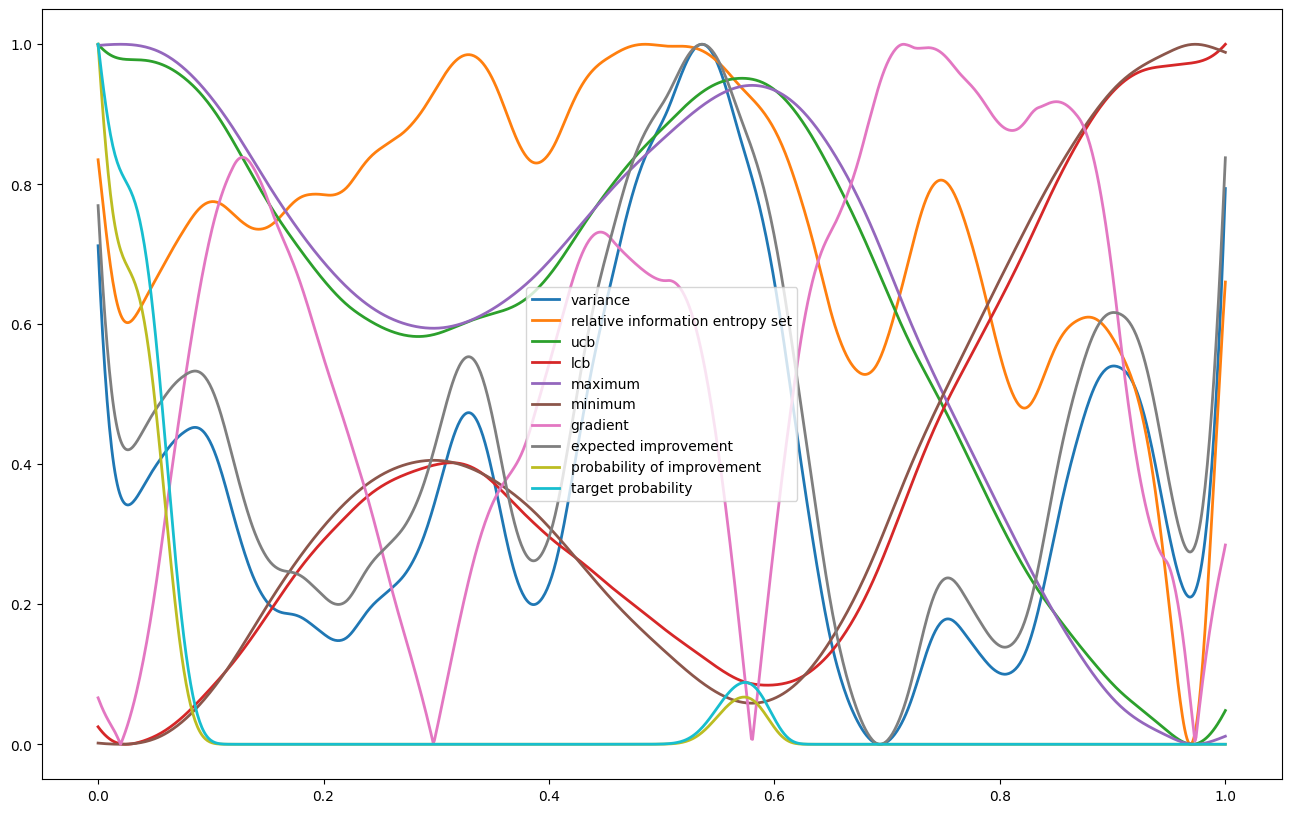

In [10]:
plt.figure(figsize=(16,10))
for acq_func in acquisition_functions:
    print("Acquisition function ",acq_func)
    res = my_gpo.evaluate_acquisition_function(x_pred, acquisition_function=acq_func)
    if len(res)==len(x_pred):
        res = res - np.min(res)
        res = res/np.max(res)
        plt.plot(x_pred,res, label = acq_func, linewidth = 2)
    else: print("Some acquisition function return a scalar score for the entirety of points. Here: ", acq_func)
plt.legend()
plt.show()


## ask()ing for Optimal Evaluations
with several optimization methods and acquisition functions

In [11]:
#let's test the asks:
bounds = np.array([[0.0,1.0]])
for acq_func in acquisition_functions:
    for method in ["global","local","hgdl"]:
        print("Acquisition function ", acq_func," and method ",method)
        new_suggestion = my_gpo.ask(bounds, acquisition_function=acq_func, 
                                    method=method, max_iter = 2,)
        print("led to new suggestion: \n", new_suggestion)
        print("")


Acquisition function  variance  and method  global
led to new suggestion: 
 {'x': array([[0.53732354]]), 'f(x)': array([0.02515862]), 'opt_obj': None}

Acquisition function  variance  and method  local
led to new suggestion: 
 {'x': array([[0.94729954]]), 'f(x)': array([0.01255391]), 'opt_obj': None}

Acquisition function  variance  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44937 instead
  warnings.warn(


led to new suggestion: 
 {'x': array([[0.53573733]]), 'f(x)': array([0.02516558]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf3425ea10>}

Acquisition function  relative information entropy  and method  global
led to new suggestion: 
 {'x': array([[0.50308075]]), 'f(x)': array([-58.75618887]), 'opt_obj': None}

Acquisition function  relative information entropy  and method  local
led to new suggestion: 
 {'x': array([[0.15617346]]), 'f(x)': array([-115.77789051]), 'opt_obj': None}

Acquisition function  relative information entropy  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.19292416]]), 'f(x)': array([-106.55947565]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf52ef8520>}

Acquisition function  relative information entropy set  and method  global
led to new suggestion: 
 {'x': array([[0.47674428]]), 'f(x)': array([-58.47473442]), 'opt_obj': None}

Acquisition function  relative information entropy set  and method  local
led to new suggestion: 
 {'x': array([[0.54813678]]), 'f(x)': array([-63.31707376]), 'opt_obj': None}

Acquisition function  relative information entropy set  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.51558138]]), 'f(x)': array([-58.79785376]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf341abdf0>}

Acquisition function  ucb  and method  global
led to new suggestion: 
 {'x': array([[0.00076715]]), 'f(x)': array([1.80047081]), 'opt_obj': None}

Acquisition function  ucb  and method  local
led to new suggestion: 
 {'x': array([[0.35699341]]), 'f(x)': array([0.46624671]), 'opt_obj': None}

Acquisition function  ucb  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.57123937]]), 'f(x)': array([1.63491685]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf14787d30>}

Acquisition function  lcb  and method  global
led to new suggestion: 
 {'x': array([[0.99279058]]), 'f(x)': array([2.37103985]), 'opt_obj': None}

Acquisition function  lcb  and method  local
led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([2.4106103]), 'opt_obj': None}

Acquisition function  lcb  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.31366718]]), 'f(x)': array([0.34368777]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf14676140>}

Acquisition function  maximum  and method  global
led to new suggestion: 
 {'x': array([[0.03137762]]), 'f(x)': array([1.38580714]), 'opt_obj': None}

Acquisition function  maximum  and method  local
led to new suggestion: 
 {'x': array([[0.23015912]]), 'f(x)': array([0.16236144]), 'opt_obj': None}

Acquisition function  maximum  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.01996656]]), 'f(x)': array([1.38883372]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf1453e8f0>}

Acquisition function  minimum  and method  global
led to new suggestion: 
 {'x': array([[0.96713605]]), 'f(x)': array([2.00848779]), 'opt_obj': None}

Acquisition function  minimum  and method  local
led to new suggestion: 
 {'x': array([[0.20875193]]), 'f(x)': array([-0.27666675]), 'opt_obj': None}

Acquisition function  minimum  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.97329539]]), 'f(x)': array([2.01152289]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf1441b040>}

Acquisition function  gradient  and method  global
led to new suggestion: 
 {'x': array([[0.71108011]]), 'f(x)': array([1.1380109]), 'opt_obj': None}

Acquisition function  gradient  and method  local
led to new suggestion: 
 {'x': array([[0.3525234]]), 'f(x)': array([0.40231482]), 'opt_obj': None}

Acquisition function  gradient  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.71459451]]), 'f(x)': array([1.13994862]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf144e59c0>}

Acquisition function  expected improvement  and method  global
led to new suggestion: 
 {'x': array([[0.52800361]]), 'f(x)': array([0.06308627]), 'opt_obj': None}

Acquisition function  expected improvement  and method  local
led to new suggestion: 
 {'x': array([[0.25432616]]), 'f(x)': array([0.04100818]), 'opt_obj': None}

Acquisition function  expected improvement  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.53574055]]), 'f(x)': array([0.06328685]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf144e6440>}

Acquisition function  probability of improvement  and method  global
led to new suggestion: 
 {'x': array([[0.00027755]]), 'f(x)': array([0.13020579]), 'opt_obj': None}

Acquisition function  probability of improvement  and method  local
led to new suggestion: 
 {'x': array([[0.3475026]]), 'f(x)': array([1.82398368e-34]), 'opt_obj': None}

Acquisition function  probability of improvement  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.57315594]]), 'f(x)': array([0.00884091]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf80617340>}

Acquisition function  target probability  and method  global
led to new suggestion: 
 {'x': array([[0.00198484]]), 'f(x)': array([-0.10487144]), 'opt_obj': None}

Acquisition function  target probability  and method  local
led to new suggestion: 
 {'x': array([[0.17564614]]), 'f(x)': array([-0.5]), 'opt_obj': None}

Acquisition function  target probability  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on p

led to new suggestion: 
 {'x': array([[0.33502498]]), 'f(x)': array([-0.5]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf14319ae0>}

Acquisition function  total correlation  and method  global
led to new suggestion: 
 {'x': array([[0.52341249]]), 'f(x)': array([-3.6364059]), 'opt_obj': None}

Acquisition function  total correlation  and method  local
led to new suggestion: 
 {'x': array([[1.]]), 'f(x)': array([-5.42140734]), 'opt_obj': None}

Acquisition function  total correlation  and method  hgdl


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  r = 1. / np.min(eig)
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/

led to new suggestion: 
 {'x': array([[0.09838297]]), 'f(x)': array([-4.09984518]), 'opt_obj': <hgdl.hgdl.HGDL object at 0x7faf143e00d0>}



/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


In [12]:
#here we can test other options of the ask() command
bounds = np.array([[0.0,1.0]])
new_suggestion = my_gpo.ask(bounds, acquisition_function="total_correlation", method="global",
                            max_iter=10, n = 5, info = True)
my_gpo.ask(bounds, n = 5, acquisition_function="variance", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 1, acquisition_function="relative information entropy", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 2, acquisition_function="expected improvement", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 1, acquisition_function="variance", vectorized=True, method = 'global')
my_gpo.ask(bounds, n = 3, acquisition_function="variance", vectorized=True, method = 'hgdl')
print(new_suggestion)

/home/marcus/Coding/gpCAM/gpcam/gp_optimizer.py:793: UserWarning: You specified n>1 and method != 'hgdl' in ask(). The acquisition function has therefore been changed to 'total correlation'
  warnings.warn("You specified n>1 and method != 'hgdl' in ask(). The acquisition function "


differential_evolution step 1: f(x)= 20.786899439153018
differential_evolution step 2: f(x)= 20.786899439153018
differential_evolution step 3: f(x)= 20.786899439153018
differential_evolution step 4: f(x)= 20.786899439153018
differential_evolution step 5: f(x)= 20.786899439153018
differential_evolution step 6: f(x)= 20.26604209150213
differential_evolution step 7: f(x)= 20.26604209150213
differential_evolution step 8: f(x)= 20.26604209150213
differential_evolution step 9: f(x)= 20.26604209150213
differential_evolution step 10: f(x)= 20.26604209150213


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42887 instead
  warnings.warn(
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, m

{'x': array([[0.59160943],
       [0.6304071 ],
       [0.53960185],
       [0.03616106],
       [0.43000242]]), 'f(x)': array([-20.26604209]), 'opt_obj': None}


In [13]:
#We can also ask for the best subset of a candidate set

In [14]:
my_gpo.ask([np.array([1.]),np.array([2.])], n = 3, acquisition_function="variance", vectorized=True, method = 'hgdl')

{'x': array([[2.],
        [1.]]),
 'f(x)': array([1.97458412, 0.02133554]),
 'opt_obj': None}

In [15]:
bounds = np.array([[0.0,1.0]])

#You can even start an ask() search asynchronously and check back later what was found
new_suggestion = my_gpo.ask(bounds, acquisition_function=acquisition_functions[0], method="hgdlAsync")
time.sleep(10)
print(new_suggestion["opt_obj"])
#And we have to cancel that trainig and possibly kill the client
new_suggestion["opt_obj"].kill_client()

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46041 instead
  warnings.warn(
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, m

[{'x': array([0.53573935]),
  'f(x)': np.float64(-0.02516557626131366),
  'classifier': 'minimum',
  'Hessian eigvals': array([5.52691226]),
  'df/dx': array([3.75033338e-07]),
  '|df/dx|': np.float64(3.750333377183779e-07),
  'radius': np.float64(0.1809328523309829)},
 {'x': array([0.90109051]),
  'f(x)': np.float64(-0.01662349950066533),
  'classifier': 'minimum',
  'Hessian eigvals': array([3.1525893]),
  'df/dx': array([5.55817614e-05]),
  '|df/dx|': np.float64(5.558176141562399e-05),
  'radius': np.float64(0.3171995793330396)},
 {'x': array([0.32869876]),
  'f(x)': np.float64(-0.015384534274037964),
  'classifier': 'minimum',
  'Hessian eigvals': array([7.74647013]),
  'df/dx': array([2.96651592e-06]),
  '|df/dx|': np.float64(2.9665159217984183e-06),
  'radius': np.float64(0.1290910547588069)}]